# *k*-NN Editing  
An evaluation of the impact of two basic instance selection (case-base editing) algorithms.
- **Condensed Nearest Neighbour**  
Hart P. The condensed nearest neighbor rule (Corresp.). IEEE transactions on information theory. 1968 May;14(3):515-6.  
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.294.6968&rep=rep1&type=pdf
- **Conservative Redundancy Removal**    
Delany, S. J., & Cunningham, P. (2004, August). An analysis of case-base editing in a spam filtering system. In European Conference on Case-Based Reasoning (pp. 128-141). Springer, Berlin, Heidelberg.
https://arrow.tudublin.ie/cgi/viewcontent.cgi?article=1034&context=scschcomcon


Basic implementations of both algorithms are available in `kNNEdit.py`.   
These implementations only work for binary classification tasks. 

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import kNNDataLoader
from kNNEdit import kNNCRR, kNNCNN

## Demonstration on 2D data  
AthleteSelection dataset

In [2]:
athlete = pd.read_csv('AthleteSelection.csv',index_col = 'Athlete')
athlete = athlete.sample(frac=1) # Shuffle the data
#athlete

In [3]:
y = athlete.pop('Selected').values
X = athlete.values
names = athlete.index
q = [5.0,7.5]
X.shape

(20, 2)

In [4]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
q_scaled = scaler.transform([q])
X_scaled.shape

(20, 2)

### Conservative Redundancy Removal (CRR)
Using `kNNCRR` class from `kNNEdit.py`

In [5]:
crr = kNNCRR()
X_crr, y_crr = crr.fit(X_scaled,y)
X.shape, X_crr.shape

((20, 2), (5, 2))

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
color= ['red' if l == 'No' else 'green' for l in y]
x1 = X_scaled[:,0]
x2 = X_scaled[:,1]
xe1 = X_crr[:,0]
xe2 = X_crr[:,1]
plt.figure(figsize=(7,6))
plt.scatter(xe1,xe2, color='yellow', s = 100)
plt.scatter(x1,x2, color=color)
plt.scatter(q_scaled[0,0],q_scaled[0,1],color='black')
plt.annotate('q',(q_scaled[0,0]+0.05,q_scaled[0,1]))
plt.title("Athlete Selection (Normalized)")
plt.xlabel("Speed N(0,1)")
plt.ylabel("Agility N(0,1)")
plt.grid()
red_patch = mpatches.Patch(color='red', label='Not Selected')
blue_patch = mpatches.Patch(color='green', label='Selected')
plt.legend(handles=[red_patch, blue_patch],loc=4)
for i, txt in enumerate(names):
    plt.annotate(txt, (x1[i]+0.05, x2[i]))

Examples picked by Conservative Redundancy Removal marked in yellow. 

### Condensed Nearest Neighbour (CNN)
Using `kNNCNN` class from `kNNEdit.py`

In [7]:
cnn = kNNCNN()
X_cnn, y_cnn = cnn.fit(X_scaled,y)
X.shape, X_cnn.shape

Pass 1 Added 5
Pass 2 Added 0


((20, 2), (6, 2))

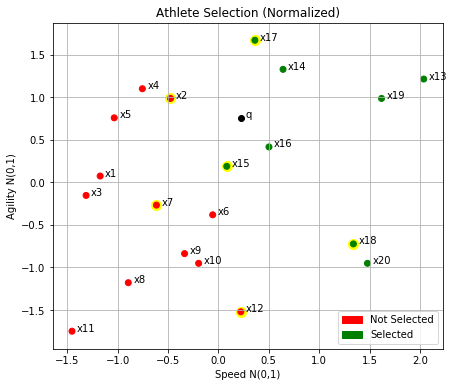

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
color= ['red' if l == 'No' else 'green' for l in y]
x1 = X_scaled[:,0]
x2 = X_scaled[:,1]
xe1 = X_cnn[:,0]
xe2 = X_cnn[:,1]
plt.figure(figsize=(7,6))
plt.scatter(xe1,xe2, color='yellow', s = 100)
plt.scatter(x1,x2, color=color)
plt.scatter(q_scaled[0,0],q_scaled[0,1],color='black')
plt.annotate('q',(q_scaled[0,0]+0.05,q_scaled[0,1]))
plt.title("Athlete Selection (Normalized)")
plt.xlabel("Speed N(0,1)")
plt.ylabel("Agility N(0,1)")
plt.grid()
red_patch = mpatches.Patch(color='red', label='Not Selected')
blue_patch = mpatches.Patch(color='green', label='Selected')
plt.legend(handles=[red_patch, blue_patch],loc=4)
for i, txt in enumerate(names):
    plt.annotate(txt, (x1[i]+0.05, x2[i]))

Examples picked by Condensed Nearest Neighbour shown in yellow. 

## Evaluation on three datasets

In [9]:
kNN = KNeighborsClassifier()
crr = kNNCRR()
Name_arr, X_dir, y_dir = kNNDataLoader.data_loader()
Name_arr

['Credit', 'HTRU', 'Shuttle', 'Letter']

In [10]:
from sklearn.datasets import load_breast_cancer
bc = load_breast_cancer()
Name_arr = ['Breast','HTRU','Credit'] # Binary classification tasks only.
#Name_arr = ['Breast','HTRU']

y_dir['Breast']=bc.target
X_dir['Breast']=bc.data

The Credit dataset is large so it takes a long time to run (>10 mins) so consider running on the other tso datasets only.

In [11]:
Edit_sizes = {}
Edit_accs = {}
Max_pass = 3
for ds in Name_arr:
    sizes = {}
    accs = {}
    X_train, X_test, y_train, y_test = train_test_split(X_dir[ds],y_dir[ds], test_size = 1/2)
    print(X_train.shape,X_test.shape)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Full training data
    kNN = KNeighborsClassifier()
    kNN = kNN.fit(X_train,y_train)
    y_pred = kNN.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    print(ds,'Acc',acc)
    sizes['Full']= y_train.shape[0]
    accs['Full']= acc
    
    # CNN
    cnn = kNNCNN()
    X_cnn, y_cnn = cnn.fit(X_train,y_train)
    kNNcnn = kNN.fit(X_cnn,y_cnn)
    y_pred = kNNcnn.predict(X_test)
    print(y_test[:10],y_pred[:10])
    acc = accuracy_score(y_test,y_pred)
    print(ds,y_cnn.shape,'CNN Acc',acc)
    sizes['CNN']= y_cnn.shape[0]
    accs['CNN']= acc

    # CRR
    crr = kNNCRR()
    X_crr, y_crr = crr.fit(X_train,y_train)
    kNNcrr = kNN.fit(X_crr,y_crr)
    y_pred = kNNcrr.predict(X_test)
    print(y_test[:10],y_pred[:10])
    acc = accuracy_score(y_test,y_pred)
    print(ds,y_crr.shape,'Crr Acc',acc)
    sizes['CRR']= y_crr.shape[0]
    accs['CRR']= acc

    Edit_sizes[ds]=sizes
    Edit_accs[ds]=accs

(284, 30) (285, 30)
Breast Acc 0.9438596491228071
Pass 1 Added 29
Pass 2 Added 16
Pass 3 Added 1
Pass 4 Added 0
[1 1 1 1 1 1 1 1 0 0] [1 1 1 1 1 1 1 1 0 0]
Breast (47,) CNN Acc 0.9508771929824561
[1 1 1 1 1 1 1 1 0 0] [1 1 1 1 1 1 1 1 0 0]
Breast (38,) Crr Acc 0.9192982456140351
(8949, 8) (8949, 8)
HTRU Acc 0.9778746228628897
Pass 1 Added 608
Pass 2 Added 210
Pass 3 Added 8
Pass 4 Added 1
Pass 5 Added 0
[0 1 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0]
HTRU (828,) CNN Acc 0.9776511342049391
[0 1 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0]
HTRU (552,) Crr Acc 0.97429880433568
(15000, 23) (15000, 23)
Credit Acc 0.7917333333333333
Pass 1 Added 5182
Pass 2 Added 1708
Pass 3 Added 140
Pass 4 Added 7
Pass 5 Added 5
Pass 6 Added 4
Pass 7 Added 4
Pass 8 Added 6
Pass 9 Added 5
Pass 10 Added 4
Pass 11 Added 5
Pass 12 Added 3
Pass 13 Added 2
Pass 14 Added 6
Pass 15 Added 4
Pass 16 Added 5
Pass 17 Added 5
Pass 18 Added 5
Pass 19 Added 4
Pass 20 Added 5
[0 0 0 0 0 1 0 0 0 0] [0 0 0 0 0 1 0 0 0 1]
Credit (7110

In [12]:
resA_pd = pd.DataFrame(Edit_accs)
resS_pd = pd.DataFrame(Edit_sizes)

In [13]:
resA = resA_pd.T
resA['CNN%']=resA['CNN']/resA['Full']
resA['CRR%']=resA['CRR']/resA['Full']
resA

,Full,CNN,CRR,CNN%,CRR%
Breast,0.943860,0.950877,0.919298,1.007435,0.973978
HTRU,0.977875,0.977651,0.974299,0.999771,0.996343
Credit,0.791733,0.779733,0.766867,0.984843,0.968592


In [14]:
resS = resS_pd.T
resS['CNN%']=resS['CNN']/resS['Full']
resS['CRR%']=resS['CRR']/resS['Full']
resS

,Full,CNN,CRR,CNN%,CRR%
Breast,284,47,38,0.165493,0.133803
HTRU,8949,828,552,0.092524,0.061683
Credit,15000,7110,4430,0.474000,0.295333


In [15]:
resA_pd

,Breast,HTRU,Credit
Full,0.943860,0.977875,0.791733
CNN,0.950877,0.977651,0.779733
CRR,0.919298,0.974299,0.766867


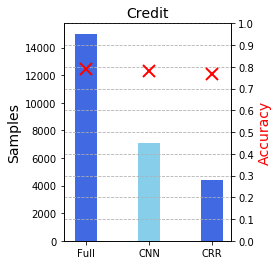

In [16]:
ds = 'Credit' # Change to 'HTRU' or 'Credit' to produce plots for other datasets.
width = .35 # width of a bar

ax1=resS_pd[ds].plot(kind='bar', width = width, 
                                 figsize=(3,4),
                                 color = ('royalblue','skyblue'))
ax2=resA_pd[ds].plot(secondary_y=True, color = 'r', markersize=12, 
                             mew =2, marker = 'x', linewidth = 0)

plt.xlim([-width, 3-2*width])
ax2.set_ylim(0,1)
ax1.set_ylabel('Samples',fontsize = 14)
#ax1.set_ylim(0,100)

ax2.set_ylabel('Accuracy', color = 'r', fontsize = 14)
ax2.set_title(ds, fontsize = 14)
ax2.set_yticks(np.arange(0, 1.1, 0.1))

plt.grid(which='both',linestyle='--')
plt.show()